In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Load raw combined data

In [8]:
# Load movie+book data
import pandas as pd
all_data_df = pd.read_pickle('../dump/combined_correctRT_data')

In [18]:
all_data_df.shape

(1370, 29)

In [21]:
all_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1370 entries, 0 to 1369
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   movie_title          1370 non-null   object        
 1   rating               1370 non-null   float64       
 2   vote                 1370 non-null   int64         
 3   certificate          1370 non-null   object        
 4   genre                1370 non-null   object        
 5   release_date         1370 non-null   datetime64[ns]
 6   metascore            481 non-null    float64       
 7   keywords             1370 non-null   object        
 8   budget               965 non-null    float64       
 9   opening_weekend_usa  817 non-null    float64       
 10  gross_usa            932 non-null    float64       
 11  gross_world          995 non-null    float64       
 12  runtime              1354 non-null   float64       
 13  director             1370 non-nul

In [22]:
all_df = all_data_df.drop(columns=['vote','metascore','keywords',\
                                   'link_d','link_s','link_w',\
                                   'book_title','rating_value','rating_count','review_count']).\
                    drop_duplicates(subset=['movie_title','director'])
all_df.rename(columns = {'certificate':'MPAA','star':'actor','year':'publish_year'},inplace=True)

In [23]:
all_df = all_df.dropna().reset_index()

In [24]:
all_df.head()

,index,movie_title,rating,MPAA,genre,release_date,budget,opening_weekend_usa,gross_usa,gross_world,runtime,director,writer,actor,distributor,language,country,author,page,publish_year
0,1,The Godfather,9.2,R,"[Crime, Drama]",1972-03-24,6000000.0,302393.0,134966411.0,2.461210e+08,175.0,Francis Ford Coppola,"[Mario Puzo, Francis Ford Coppola]","[Marlon Brando, Al Pacino, James Caan]",ParamountPictures,"[English, Italian, Latin]",[USA],Mario Puzo,448.0,1969.0
1,2,Harry Potter and the Sorcerer's Stone,7.6,PG,"[Adventure, Family, Fantasy]",2001-11-16,125000000.0,90294621.0,318087620.0,1.006918e+09,159.0,Chris Columbus,"[J.K. Rowling, Steve Kloves]","[Daniel Radcliffe, Rupert Grint, Richard Harris]",WarnerBros.,[English],"[UK, USA]",J.K. Rowling,309.0,1997.0
2,4,Little Women,7.8,PG,"[Drama, Romance]",2019-12-25,40000000.0,16755310.0,108101214.0,2.166012e+08,135.0,Greta Gerwig,"[Greta Gerwig, Louisa May Alcott]","[Saoirse Ronan, Emma Watson, Florence Pugh]",ColumbiaPictures,"[English, French]",[USA],Louisa May Alcott,449.0,1868.0
3,5,Little Women,7.3,PG,"[Drama, Family, Romance]",1994-12-25,18000000.0,2411247.0,50083616.0,5.008362e+07,115.0,Gillian Armstrong,"[Louisa May Alcott, Robin Swicord]","[Susan Sarandon, Winona Ryder, Kirsten Dunst]",ColumbiaPictures,"[English, German, French]","[USA, Canada]",Louisa May Alcott,449.0,1868.0
4,8,Ready Player One,7.5,PG-13,"[Action, Adventure, Sci-Fi]",2018-03-29,175000000.0,41764050.0,137690172.0,5.828937e+08,140.0,Steven Spielberg,"[Zak Penn, Ernest Cline]","[Tye Sheridan, Olivia Cooke, Ben Mendelsohn]",WarnerBros.,[English],"[USA, India]",Ernest Cline,374.0,2011.0


In [25]:
all_data_df.shape

(1370, 29)

In [26]:
all_df.shape

(608, 20)

In [27]:
all_df.to_pickle('../dump/all_df')

In [17]:
all_df.columns

Index(['level_0', 'index', 'movie_title', 'rating', 'MPAA', 'genre',
       'release_date', 'budget', 'opening_weekend_usa', 'gross_usa',
       'gross_world', 'runtime', 'director', 'writer', 'actor', 'distributor',
       'language', 'country', 'author', 'page', 'publish_year',
       'book_popularity', 'author_popularity'],
      dtype='object')

## 2. Collect more features

### (1) release time of the movie

In [10]:
# Divide release_date into year, month, day of week
all_df['release_year'] = all_df['release_date'].dt.year
all_df['release_month'] = all_df['release_date'].dt.month
all_df['dow'] = all_df['release_date'].dt.weekday

### (2) director value

In [11]:
# Find corresponding value of each director when movie is released
# ['avg_rating','avg_gross'] (per movie directed)
director_df = pd.read_pickle('../dump/director_data')

In [12]:
# Find the mean rating, gross of all directors
director_rating_mean = int(director_df.rating.mean())
director_gross_mean = int(director_df.gross_usa.mean())

director_rating_mean, director_gross_mean

(6, 32634196)

In [13]:
def director_value(movie):
    """
    input: movie (each row in all_data_df)
    output: 
        - film_count: number of movies directed before the movie of interest
        - avg_rating: average rating of movies directed before the movie of interest
        - avg_gross: gross per movie before the movie of interest
    """
    
    movie_title = movie.movie_title
    director = movie.director
    year = movie.release_date

    headers = ['movie_title','director','film_count_d','avg_rating_d','avg_gross_d']
    
    # Assign default values
    film_count,avg_rating,avg_gross = 0, director_rating_mean, director_gross_mean
    
    doi_df = director_df[(director_df.director == director) & (director_df.year < year)]
    
    # Fill NaN with director's mean
    doi_df[['rating','gross_usa']].apply(lambda x: x.fillna(x.mean(),axis=0))
    
    # If there's still NaN, fill with all directors' mean
    doi_df[['rating']] = doi_df[['rating']].apply(lambda x: x.fillna(director_rating_mean,axis=0))
    doi_df[['gross_usa']] = doi_df[['gross_usa']].apply(lambda x: x.fillna(director_gross_mean,axis=0))
    
   
    if doi_df.shape[0] == 0:
        film_count,avg_rating,avg_gross = 0, director_rating_mean, director_gross_mean
    else:
        
    
    
        film_count = doi_df.shape[0]

        
        avg_rating = doi_df['rating'].mean()
        if avg_rating == np.nan:
            avg_rating = director_rating_mean

        try:
            avg_gross = int(doi_df['gross_usa'].mean())
        except ValueError:
            avg_gross = director_gross_mean
        
    
    director_value = dict(zip(headers, [movie_title,director,film_count,avg_rating,avg_gross]))
    
    return director_value

In [14]:
# Create df including columns of director film_count, avg_rating, avg_gross
# Rows correspond to rows in all_df
movie_director_df = all_df.dropna().apply(director_value,axis=1).apply(pd.Series)

In [15]:
movie_director_df

,movie_title,director,film_count_d,avg_rating_d,avg_gross_d
0,The Godfather,Francis Ford Coppola,7,5.285714,32634196
1,Harry Potter and the Sorcerer's Stone,Chris Columbus,9,6.622222,106588545
2,Little Women,Greta Gerwig,2,6.700000,24481851
3,Little Women,Gillian Armstrong,11,6.663636,24220795
4,Ready Player One,Steven Spielberg,34,7.202941,132444136
...,...,...,...,...,...
576,Never Die Alone,Ernest R. Dickerson,7,6.157143,20446469
577,Radio Free Albemuth,John Alan Simon,0,6.000000,32634196
578,The Golden Bowl,James Ivory,23,6.317391,18103663
579,The Good Mother,Leonard Nimoy,3,6.700000,117988379


In [16]:
# Merge all_df and director value
all_d_df = pd.merge(all_df, movie_director_df, left_index=True, right_index=True ,how='left')

In [17]:
# Merge all_df and director value
all_d_df = pd.merge(all_df, movie_director_df, on=['movie_title','director'] ,how='left')

In [18]:
all_d_df

,index,movie_title,rating,MPAA,genre,release_date,budget,opening_weekend_usa,gross_usa,gross_world,...,page,publish_year,book_popularity,author_popularity,release_year,release_month,dow,film_count_d,avg_rating_d,avg_gross_d
0,1,The Godfather,9.2,R,"[Crime, Drama]",1972-03-24,6000000.0,302393.0,134966411.0,2.461210e+08,...,448.0,1969.0,0.16,0.0699,1972,3,4,7,5.285714,32634196
1,2,Harry Potter and the Sorcerer's Stone,7.6,PG,"[Adventure, Family, Fantasy]",2001-11-16,125000000.0,90294621.0,318087620.0,1.006918e+09,...,309.0,1997.0,0.14,0.0149,2001,11,4,9,6.622222,106588545
2,4,Little Women,7.8,PG,"[Drama, Romance]",2019-12-25,40000000.0,16755310.0,108101214.0,2.166012e+08,...,449.0,1868.0,0.00,0.0151,2019,12,2,2,6.700000,24481851
3,8,Little Women,7.3,PG,"[Drama, Family, Romance]",1994-12-25,18000000.0,2411247.0,50083616.0,5.008362e+07,...,449.0,1868.0,0.00,0.0151,1994,12,6,11,6.663636,24220795
4,20,Ready Player One,7.5,PG-13,"[Action, Adventure, Sci-Fi]",2018-03-29,175000000.0,41764050.0,137690172.0,5.828937e+08,...,374.0,2011.0,0.00,0.0012,2018,3,3,34,7.202941,132444136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,1552,Never Die Alone,5.7,R,"[Action, Crime, Drama]",2004-03-26,3000000.0,3089993.0,5645298.0,5.923000e+06,...,480.0,2015.0,0.26,0.0093,2004,3,4,7,6.157143,20446469
577,1554,Radio Free Albemuth,5.7,R,"[Drama, Sci-Fi]",2014-06-27,3600000.0,5553.0,9365.0,9.365000e+03,...,214.0,1985.0,0.00,0.0039,2014,6,4,0,6.000000,32634196
578,1559,The Golden Bowl,5.9,R,"[Drama, Romance]",2001-05-25,15000000.0,90170.0,3050532.0,5.753678e+06,...,591.0,1904.0,0.36,0.7878,2001,5,4,23,6.317391,18103663
579,1567,The Good Mother,5.8,R,"[Drama, Romance]",1988-11-04,14000000.0,1804288.0,4764606.0,4.764606e+06,...,320.0,1986.0,1.56,0.2796,1988,11,4,3,6.700000,117988379


In [19]:
all_d_df.columns

Index(['index', 'movie_title', 'rating', 'MPAA', 'genre', 'release_date',
       'budget', 'opening_weekend_usa', 'gross_usa', 'gross_world', 'runtime',
       'director', 'writer', 'actor', 'distributor', 'language', 'country',
       'author', 'page', 'publish_year', 'book_popularity',
       'author_popularity', 'release_year', 'release_month', 'dow',
       'film_count_d', 'avg_rating_d', 'avg_gross_d'],
      dtype='object')

### (3) cast (actors) value

In [ ]:
# Find corresponding value of each director when movie is released
# ['avg_rating','avg_gross'] (per movie directed)
actor_df = pd.read_pickle('../dump/actor_correct_data')
actor_df.shape

In [ ]:
actor_df.head()

In [ ]:
actor_df.director.nunique()

In [ ]:
# Find the mean rating, gross of all directors
actor_rating_mean = int(actor_df.rating.mean())
actor_gross_mean = int(actor_df.gross_usa.mean())

actor_rating_mean, actor_gross_mean

In [ ]:
def actor_value(actor,year):
    """
    input: actor name and (release) year of the movie of interest
    output: 
        - film_count: number of movies the actor was in before the movie of interest
        - avg_rating: average rating of movies the actor was in before the movie of interest
        - avg_gross: gross per movie before the movie of interest
    """
    
    aoi_df = actor_df[(actor_df.actor == actor) & (actor_df.year.dt.year < year)].copy()
    
    # Fill NaN with actor's mean
    values={'rating':aoi_df.rating.mean(), 'gross_usa':aoi_df.gross_usa.mean()}
    aoi_df.fillna(value=values,inplace=True)
    
    # If there's still NaN, fill with all actors' mean
    values={'rating':actor_rating_mean, 'gross_usa':actor_gross_mean}
    aoi_df.fillna(value=values,inplace=True)
        
    
    # If there's no movie prior to movie of interest  
    if aoi_df.shape[0] == 0:
        film_count,avg_rating,avg_gross = 0, actor_rating_mean, actor_gross_mean
        
    else:
        
        film_count = aoi_df.shape[0]
        
        avg_rating = aoi_df['rating'].mean()
        avg_gross = aoi_df['gross_usa'].mean()

        
    
    actor_value = [film_count, avg_rating, avg_gross]
    
    print(actor,actor_value)
    
    return actor_value,aoi_df

In [ ]:
def get_cast(movie):
    """
    input: movie (each row in all_data_df)
    output: 
        - film_count: number of movies directed before the movie of interest
        - avg_rating: average rating of movies directed before the movie of interest
        - avg_gross: gross per movie before the movie of interest
    """
    
    movie_title = movie.movie_title
    year = movie.release_year
    actors = movie.actor
    lead = actors[0]
    
    film_counts = []
    ratings = []
    grosses = []
    
    for actor in actors:
        result = actor_value(actor,year)
        film_counts.append(result[0])
        ratings.append(result[1])
        grosses.append(result[2])
        
    avg_film_count = np.mean(film_counts)
    avg_rating = np.mean(ratings)
    avg_gross = np.mean(grosses)    
    
    
    lead_result = actor_value(lead,year)
    

    headers = ['movie_title','cast','avg_film_count_c','avg_rating_c','avg_gross_c',\
              'avg_film_count_l','avg_rating_l','avg_gross_l']

        
    
    cast_info = dict(zip(headers, [movie_title,actors,avg_film_count,avg_rating,avg_gross,\
                                  lead_result[0],lead_result[1],lead_result[2]]))
    
    return cast_info

In [ ]:
# Create df including columns of director film_count, avg_rating, avg_gross
# Rows correspond to rows in all_df
movie_actor_df = all_df.iloc[:2].apply(get_cast,axis=1).apply(pd.Series)

In [ ]:
# Merge all_df and cast info
all_dc_df = pd.merge(all_d_df, movie_actor_df, lon=['movie_title','director'] ,how='left')

### (4) book and author popularity

In [20]:
# Load book_history_2
book_history = pd.read_pickle('../dump/book_history_2_data')

In [21]:
book_history.sort_values('book_popularity',ascending=False)

,title,release_date,genre,title_search,search_fiction_book,author_search,search_fiction_author,book_popularity,author_popularity
664,To Die For,1995-10-06,"[Comedy, Crime, Drama]",31700,13100.0,35200,140000,2.42,0.2514
898,The Lost Weekend,1946-01-01,"[Drama, Film-Noir]",21600000,12100000.0,424000000,560000000,1.79,0.7571
712,Paper Towns,2015-07-24,"[Comedy, Drama, Mystery]",6610000,3720000.0,673000000,109000000,1.78,6.1743
53,It,2017-09-08,[Horror],98300000,55900000.0,114000000,169000000,1.76,0.6746
583,Christine,1983-12-09,"[Horror, Thriller]",6830,3990.0,31500,41600,1.71,0.7572
...,...,...,...,...,...,...,...,...,...
734,Three Days of the Condor,1975-09-25,"[Mystery, Thriller]",92,NaN,2550,12300,NaN,0.2073
810,Presumed Innocent,1990-07-27,"[Mystery, Thriller]",247,NaN,264,71400,NaN,0.0037
1078,Shalako,1968-12-13,[Western],48300,NaN,82400000,727000000,NaN,0.1133
1108,The List of Adrian Messenger,1963-05-29,"[Mystery, Thriller]",770000,NaN,25300000,663000000,NaN,0.0382


In [22]:
book_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  1166 non-null   object 
 1   release_date           1166 non-null   object 
 2   genre                  1166 non-null   object 
 3   title_search           1166 non-null   int64  
 4   search_fiction_book    1158 non-null   float64
 5   author_search          1166 non-null   int64  
 6   search_fiction_author  1166 non-null   int64  
 7   book_popularity        1158 non-null   float64
 8   author_popularity      1166 non-null   float64
dtypes: float64(3), int64(3), object(3)
memory usage: 82.1+ KB


In [23]:
all_d_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 581 entries, 0 to 580
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   index                581 non-null    int64         
 1   movie_title          581 non-null    object        
 2   rating               581 non-null    float64       
 3   MPAA                 581 non-null    object        
 4   genre                581 non-null    object        
 5   release_date         581 non-null    datetime64[ns]
 6   budget               581 non-null    float64       
 7   opening_weekend_usa  581 non-null    float64       
 8   gross_usa            581 non-null    float64       
 9   gross_world          581 non-null    float64       
 10  runtime              581 non-null    float64       
 11  director             581 non-null    object        
 12  writer               581 non-null    object        
 13  actor                581 non-null  

In [24]:
book_history['release_date'] = book_history['release_date'].astype('datetime64[ns]')

In [25]:
book_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  1166 non-null   object        
 1   release_date           1166 non-null   datetime64[ns]
 2   genre                  1166 non-null   object        
 3   title_search           1166 non-null   int64         
 4   search_fiction_book    1158 non-null   float64       
 5   author_search          1166 non-null   int64         
 6   search_fiction_author  1166 non-null   int64         
 7   book_popularity        1158 non-null   float64       
 8   author_popularity      1166 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 82.1+ KB


<AxesSubplot:>

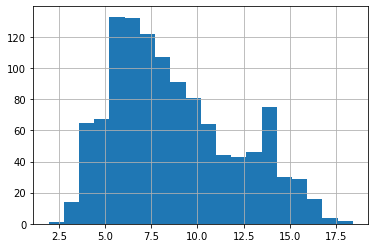

In [26]:
np.log(book_history.title_search).hist(bins=20)

<AxesSubplot:>

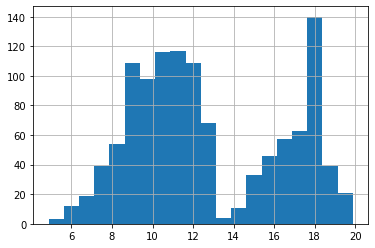

In [27]:
np.log(book_history.search_fiction_book).hist(bins=20)

<AxesSubplot:>

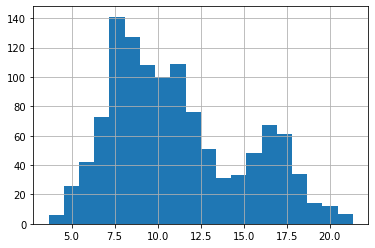

In [28]:
np.log(book_history.author_search).hist(bins=20)

<AxesSubplot:>

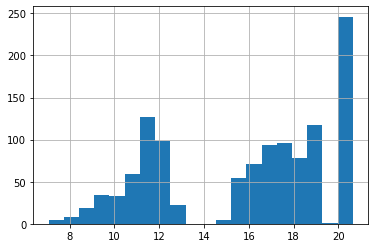

In [29]:
np.log(book_history.search_fiction_author).hist(bins=20)

In [30]:
all_d_df.shape, book_history.shape

((581, 28), (1166, 9))

In [31]:
# Merge book data with movie df
all_da_df = pd.merge(all_d_df, book_history, left_on=['movie_title','release_date'],\
                      right_on=['title','release_date'],how='left',copy=False)

In [32]:
all_da_df['log_book_search'] = np.log(all_da_df['title_search'])
all_da_df['log_author_search'] = np.log(all_da_df['author_search'])

In [33]:
all_da_df.columns

Index(['index', 'movie_title', 'rating', 'MPAA', 'genre_x', 'release_date',
       'budget', 'opening_weekend_usa', 'gross_usa', 'gross_world', 'runtime',
       'director', 'writer', 'actor', 'distributor', 'language', 'country',
       'author', 'page', 'publish_year', 'book_popularity_x',
       'author_popularity_x', 'release_year', 'release_month', 'dow',
       'film_count_d', 'avg_rating_d', 'avg_gross_d', 'title', 'genre_y',
       'title_search', 'search_fiction_book', 'author_search',
       'search_fiction_author', 'book_popularity_y', 'author_popularity_y',
       'log_book_search', 'log_author_search'],
      dtype='object')

In [34]:
all_da_df.drop(columns=['title', 'genre_y','book_popularity_x','author_popularity_x'],inplace=True)

In [35]:
all_da_df.columns

Index(['index', 'movie_title', 'rating', 'MPAA', 'genre_x', 'release_date',
       'budget', 'opening_weekend_usa', 'gross_usa', 'gross_world', 'runtime',
       'director', 'writer', 'actor', 'distributor', 'language', 'country',
       'author', 'page', 'publish_year', 'release_year', 'release_month',
       'dow', 'film_count_d', 'avg_rating_d', 'avg_gross_d', 'title_search',
       'search_fiction_book', 'author_search', 'search_fiction_author',
       'book_popularity_y', 'author_popularity_y', 'log_book_search',
       'log_author_search'],
      dtype='object')

In [36]:
all_da_df.rename(columns = {'genre_x':'genre','book_popularity_y':'book_popularity',\
                            'author_popularity_y':'author_popularity'},inplace=True)

In [37]:
all_da_df

,index,movie_title,rating,MPAA,genre,release_date,budget,opening_weekend_usa,gross_usa,gross_world,...,avg_rating_d,avg_gross_d,title_search,search_fiction_book,author_search,search_fiction_author,book_popularity,author_popularity,log_book_search,log_author_search
0,1,The Godfather,9.2,R,"[Crime, Drama]",1972-03-24,6000000.0,302393.0,134966411.0,2.461210e+08,...,5.285714,32634196,192,728.0,258,4550,0.26,0.0567,5.257495,5.552960
1,2,Harry Potter and the Sorcerer's Stone,7.6,PG,"[Adventure, Family, Fantasy]",2001-11-16,125000000.0,90294621.0,318087620.0,1.006918e+09,...,6.622222,106588545,5720,31300.0,68600,5680000,0.18,0.0121,8.651724,11.136048
2,2,Harry Potter and the Sorcerer's Stone,7.6,PG,"[Adventure, Family, Fantasy]",2001-11-16,125000000.0,90294621.0,318087620.0,1.006918e+09,...,6.622222,106588545,5720,31300.0,68600,5680000,0.18,0.0121,8.651724,11.136048
3,4,Little Women,7.8,PG,"[Drama, Romance]",2019-12-25,40000000.0,16755310.0,108101214.0,2.166012e+08,...,6.700000,24481851,214000,37500000.0,2060000,210000000,0.01,0.0098,12.273731,14.538217
4,4,Little Women,7.8,PG,"[Drama, Romance]",2019-12-25,40000000.0,16755310.0,108101214.0,2.166012e+08,...,6.700000,24481851,214000,37500000.0,2060000,210000000,0.01,0.0098,12.273731,14.538217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,1552,Never Die Alone,5.7,R,"[Action, Crime, Drama]",2004-03-26,3000000.0,3089993.0,5645298.0,5.923000e+06,...,6.157143,20446469,16700,46800.0,105000,9560000,0.36,0.0110,9.723164,11.561716
826,1554,Radio Free Albemuth,5.7,R,"[Drama, Sci-Fi]",2014-06-27,3600000.0,5553.0,9365.0,9.365000e+03,...,6.000000,32634196,1260,1270000.0,334000,107000000,0.00,0.0031,7.138867,12.718896
827,1559,The Golden Bowl,5.9,R,"[Drama, Romance]",2001-05-25,15000000.0,90170.0,3050532.0,5.753678e+06,...,6.317391,18103663,14300,44600.0,4170000,3190000,0.32,1.3072,9.568015,15.243427
828,1567,The Good Mother,5.8,R,"[Drama, Romance]",1988-11-04,14000000.0,1804288.0,4764606.0,4.764606e+06,...,6.700000,117988379,13700,8480.0,21200,69100,1.62,0.3068,9.525151,9.961756


In [38]:
all_da_df.drop_duplicates(subset=['movie_title','release_date'],inplace=True)

In [39]:
all_da_df.shape

(581, 34)

In [40]:
all_da_df.columns

Index(['index', 'movie_title', 'rating', 'MPAA', 'genre', 'release_date',
       'budget', 'opening_weekend_usa', 'gross_usa', 'gross_world', 'runtime',
       'director', 'writer', 'actor', 'distributor', 'language', 'country',
       'author', 'page', 'publish_year', 'release_year', 'release_month',
       'dow', 'film_count_d', 'avg_rating_d', 'avg_gross_d', 'title_search',
       'search_fiction_book', 'author_search', 'search_fiction_author',
       'book_popularity', 'author_popularity', 'log_book_search',
       'log_author_search'],
      dtype='object')

In [41]:
all_df = all_da_df

In [42]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 581 entries, 0 to 829
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   index                  581 non-null    int64         
 1   movie_title            581 non-null    object        
 2   rating                 581 non-null    float64       
 3   MPAA                   581 non-null    object        
 4   genre                  581 non-null    object        
 5   release_date           581 non-null    datetime64[ns]
 6   budget                 581 non-null    float64       
 7   opening_weekend_usa    581 non-null    float64       
 8   gross_usa              581 non-null    float64       
 9   gross_world            581 non-null    float64       
 10  runtime                581 non-null    float64       
 11  director               581 non-null    object        
 12  writer                 581 non-null    object        
 13  actor

In [43]:
all_df[all_df.search_fiction_book.isna() == True]

,index,movie_title,rating,MPAA,genre,release_date,budget,opening_weekend_usa,gross_usa,gross_world,...,avg_rating_d,avg_gross_d,title_search,search_fiction_book,author_search,search_fiction_author,book_popularity,author_popularity,log_book_search,log_author_search
38,61,Shutter Island,8.2,R,"[Mystery, Thriller]",2010-02-19,80000000.0,41062440.0,128012934.0,294804195.0,...,7.383333,33200799,2590,NaN,9620,41500000,NaN,0.0002,7.859413,9.171600
95,135,The Da Vinci Code,6.6,PG-13,"[Mystery, Thriller]",2006-05-19,125000000.0,77073388.0,217536138.0,760006945.0,...,6.430000,75985194,16100,NaN,14700000,13000000,NaN,1.1308,9.686575,16.503358
531,765,In the Cut,5.3,R,"[Mystery, Thriller]",2003-10-31,12000000.0,97625.0,4750602.0,23726793.0,...,6.725000,18188941,3780,NaN,13600,7250000,NaN,0.0019,8.237479,9.517825
660,971,Presumed Innocent,6.9,R,"[Mystery, Thriller]",1990-07-27,22000000.0,11718981.0,86303188.0,221303188.0,...,6.575000,22846388,247,NaN,264,71400,NaN,0.0037,5.509388,5.575949


In [44]:
# Fill up the four missing values
all_df.loc[38,'search_fiction_book'] = 29600
all_df.loc[95,'search_fiction_book'] = 44200
all_df.loc[531,'search_fiction_book'] = 26200
all_df.loc[660,'search_fiction_book'] = 231000

In [45]:
# Re-evaluate book_popularity

In [46]:
all_df['book_popularity_test'] = all_df['title_search'] / all_df['search_fiction_book']

<AxesSubplot:>

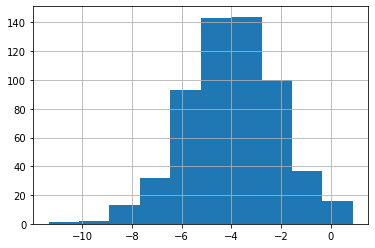

In [47]:
# log plot distribution looks ok
np.log(all_df['book_popularity_test']).hist()

In [48]:
all_df['log_book_popularity'] = np.log(all_df['book_popularity_test'])

In [49]:
# Same for author populatiry
all_df['author_popularity_test'] = all_df['author_search'] / all_df['search_fiction_author']

<AxesSubplot:>

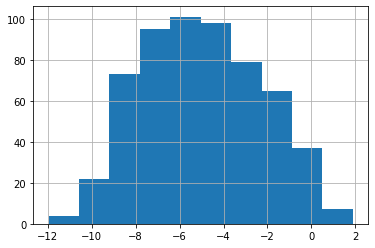

In [50]:
np.log(all_df['author_popularity_test']).hist()

In [51]:
all_df['log_author_popularity'] = np.log(all_df['author_popularity_test'])

In [52]:
all_df.shape

(581, 38)

In [53]:
all_df.to_pickle('../dump/complete_data')

## 3. Simple EDA

In [54]:
all_df.corr()

,index,rating,budget,opening_weekend_usa,gross_usa,gross_world,runtime,page,publish_year,release_year,...,author_search,search_fiction_author,book_popularity,author_popularity,log_book_search,log_author_search,book_popularity_test,log_book_popularity,author_popularity_test,log_author_popularity
index,1.000000,-0.500822,-0.358683,-0.434366,-0.551645,-0.540932,-0.311140,-0.083602,0.053707,-0.147703,...,-0.044007,-0.214454,-0.029958,-0.054590,-0.312233,-0.233912,-0.032660,-0.039058,-0.054586,-0.002234
rating,-0.500822,1.000000,0.023923,0.053388,0.282861,0.234868,0.334279,0.043180,-0.038189,-0.174547,...,0.006805,0.108155,0.071661,-0.028846,0.083681,-0.010566,0.070186,0.146091,-0.028851,0.031649
budget,-0.358683,0.023923,1.000000,0.624763,0.560477,0.659871,0.196036,0.067559,-0.057722,0.278532,...,-0.038852,-0.047739,-0.005430,-0.033175,0.123458,0.102806,-0.000830,0.007546,-0.033176,-0.109422
opening_weekend_usa,-0.434366,0.053388,0.624763,1.000000,0.838640,0.846679,0.142887,0.126410,0.015840,0.233311,...,0.048301,0.009510,0.052966,0.106362,0.230270,0.213246,0.059285,0.055683,0.106360,-0.011105
gross_usa,-0.551645,0.282861,0.560477,0.838640,1.000000,0.935175,0.246334,0.117594,-0.047797,0.025183,...,-0.000783,0.032521,0.061272,0.036164,0.147725,0.099596,0.065406,0.112546,0.036161,0.016074
gross_world,-0.540932,0.234868,0.659871,0.846679,0.935175,1.000000,0.253615,0.119465,-0.030800,0.138007,...,0.027979,0.046062,0.036880,0.075504,0.194063,0.169375,0.043641,0.072472,0.075500,-0.011365
runtime,-0.311140,0.334279,0.196036,0.142887,0.246334,0.253615,1.000000,0.274192,0.007373,-0.102181,...,-0.036218,-0.030183,0.020261,0.027407,0.008271,-0.014548,0.025347,0.087472,0.027404,0.115522
page,-0.083602,0.043180,0.067559,0.126410,0.117594,0.119465,0.274192,1.000000,-0.066636,-0.056274,...,0.080310,0.020895,0.103678,0.082863,0.118917,0.108527,0.104632,0.125037,0.082858,0.158810
publish_year,0.053707,-0.038189,-0.057722,0.015840,-0.047797,-0.030800,0.007373,-0.066636,1.000000,0.250566,...,-0.023830,-0.034094,-0.060059,0.013548,0.006531,0.002759,-0.058661,-0.197883,0.013550,-0.184548
release_year,-0.147703,-0.174547,0.278532,0.233311,0.025183,0.138007,-0.102181,-0.056274,0.250566,1.000000,...,-0.103776,-0.101899,-0.114305,-0.019632,0.276985,0.262247,-0.111635,-0.384410,-0.019634,-0.447618


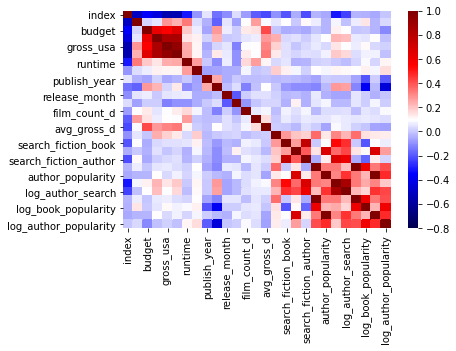

In [55]:
# sns.heatmap(all_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);
sns.heatmap(all_df.corr(), cmap="seismic", vmin=-0.8, vmax=1);

In [56]:
continuous_variables = ['opening_weekend_usa', 'gross_usa', 'gross_world','rating', \
                        'budget','runtime','release_year', 'release_month','dow',\
                        'film_count_d', 'avg_rating_d', 'avg_gross_d', \
        'page', 'publish_year','log_book_search','title_search','search_fiction_book', \
        'log_author_search','author_search', 'search_fiction_author',\
       'book_popularity', 'author_popularity']
all_df_select = all_df[continuous_variables]

In [57]:
# sns.pairplot(all_df_select)

## 4. Clean each column
Clean the format and convert data type if necessarry for later steps.

### (1) Target variable
### (i) opening_weekend_usa

<AxesSubplot:>

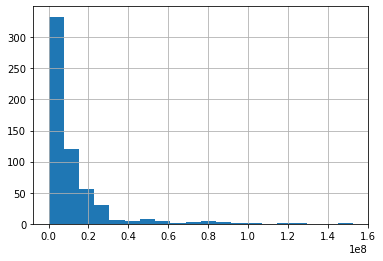

In [58]:
# Examine the distribution. Pretty skewed.
all_df['opening_weekend_usa'].hist(bins=20)

<AxesSubplot:>

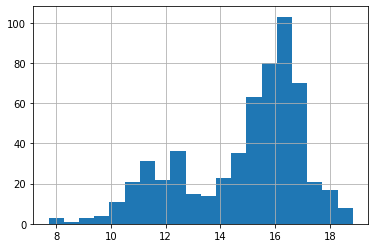

In [59]:
# Try log. Slightly better. Still not very normal
np.log(all_df['opening_weekend_usa']).hist(bins=20)

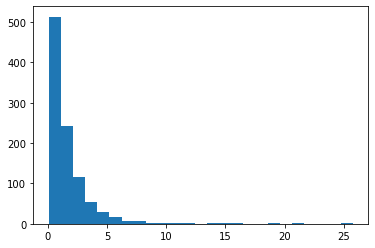

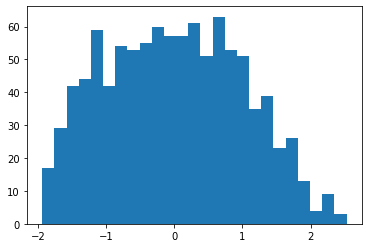

In [60]:
# demonstration of the power transform on data with a skew
from numpy import exp
from numpy.random import randn
from sklearn.preprocessing import PowerTransformer
from matplotlib import pyplot as plt
# generate gaussian data sample
data = randn(1000)
# add a skew to the data distribution
data = exp(data)
# histogram of the raw data with a skew
plt.hist(data, bins=25)
plt.show()
# reshape data to have rows and columns
data = data.reshape((len(data),1))
# power transform the raw data
power = PowerTransformer(method='yeo-johnson', standardize=True)
data_trans = power.fit_transform(data)
# histogram of the transformed data
plt.hist(data_trans, bins=25)
plt.show()

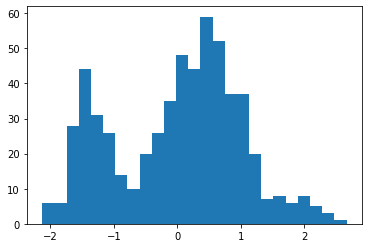

In [61]:
# Explore power transform
data = all_df[['opening_weekend_usa']]
power = PowerTransformer(method='yeo-johnson', standardize=True)
data_trans = power.fit_transform(data)
plt.hist(data_trans, bins=25)
plt.show()

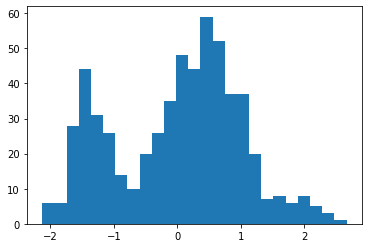

In [62]:
# Explore power transform (box-cox)
data = all_df[['opening_weekend_usa']]
power = PowerTransformer(method='box-cox', standardize=True)
data_trans = power.fit_transform(data)
plt.hist(data_trans, bins=25)
plt.show()

In [63]:
# Seems like both log and power transform are similarr
all_df['log_owu'] = np.log(all_df['opening_weekend_usa'])

data = all_df[['opening_weekend_usa']]
power = PowerTransformer(method='box-cox', standardize=True)
data_trans = power.fit_transform(data)
all_df['log_owu'] = data_trans.reshape(len(data),)

In [64]:
all_df.shape

(581, 39)

### (ii) IMDb rating

<AxesSubplot:>

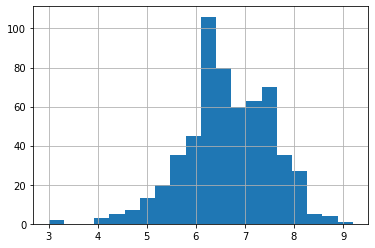

In [65]:
# Distribution looks ok. Will keep it as it is for now.
all_df['rating'].hist(bins=20)

### (2) Independent variables (predictors)
### (a) Continuous variables

#### 1. time

<AxesSubplot:>

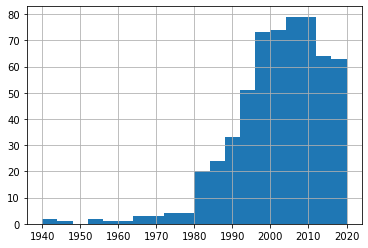

In [66]:
# Movie release year
all_df['release_year'].hist(bins=20)

<AxesSubplot:>

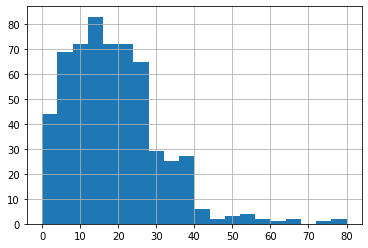

In [67]:
# Convert to "how old" the movie is
(2020-all_df['release_year']).hist(bins=20)

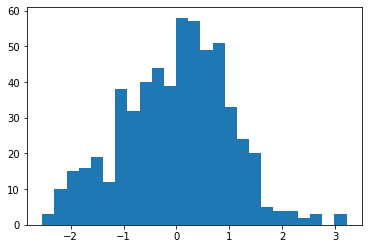

In [68]:
# Try power transform
data = (all_df[['release_year']].apply(lambda x: 2021 - x))
power = PowerTransformer(method='box-cox', standardize=True)
data_trans = power.fit_transform(data)
plt.hist(data_trans, bins=25)
plt.show()
# Create a new column in case needed in the futurre
all_df['T_movie_age'] = data_trans.reshape(len(data),)

<AxesSubplot:>

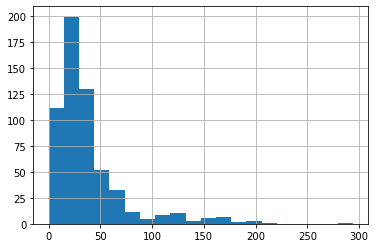

In [69]:
# Also check for book first published year
(2020-all_df['publish_year']).hist(bins=20)

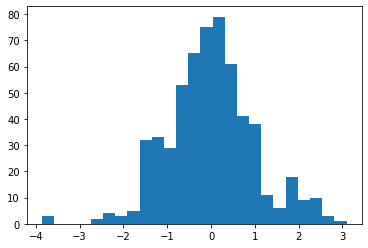

In [70]:
# Try power transform
data = (all_df[['publish_year']].apply(lambda x: 2021 - x))
power = PowerTransformer(method='box-cox', standardize=True)
data_trans = power.fit_transform(data)
plt.hist(data_trans, bins=25)
plt.show()
# Create a new column in case needed in the futurre
all_df['T_book_age'] = data_trans.reshape(len(data),)

### (b) Categorical variables - single label

### 1. MPAA rating

In [71]:
# Find the distribution and keep only the top frequent categories
all_df.MPAA.value_counts()

R           273
PG-13       184
PG          105
G            13
Passed        3
Not           1
M/PG          1
Approved      1
Name: MPAA, dtype: int64

In [72]:
# Keep only the top 3
MPAA_discard = ['G','Passed','Not','X','M/PG','Approved','NC-17','Unrated']
all_df.MPAA.replace(MPAA_discard,'Other',inplace=True)

In [73]:
all_df.MPAA.value_counts()

R        273
PG-13    184
PG       105
Other     19
Name: MPAA, dtype: int64

### 2. distributor

In [74]:
all_df.distributor.value_counts().head(5)

WarnerBros.            47
ColumbiaPictures       35
ParamountPictures      34
UniversalPictures      30
TwentiethCenturyFox    24
Name: distributor, dtype: int64

In [75]:
# Keep only the top 3
distributor_keep = ['WarnerBros.','ParamountPictures','ColumbiaPictures','UniversalPictures',\
             'TwentiethCenturyFox','TwentiethCenturyFox']
distributor_discard = list(set(all_df.distributor.unique()).difference(set(distributor_keep)))
all_df.distributor.replace(distributor_discard,'Other',inplace=True)

In [76]:
all_df.distributor.value_counts()

Other                  411
WarnerBros.             47
ColumbiaPictures        35
ParamountPictures       34
UniversalPictures       30
TwentiethCenturyFox     24
Name: distributor, dtype: int64

### (b) Categorical variables - multi label

### 1. genre
Find the top frequent genres and convert the column from list to set in preparation for `MultiLabelBinarizer()`.

In [77]:
# Find the top 10 genre
genre_all = []
for row in all_df.genre:
    genre_all += row
genre_count = []
for genre in set(genre_all):
    genre_count.append({'genre':genre,'count':genre_all.count(genre)})
sorted(genre_count, key = lambda i: i['count'],reverse=True)

[{'genre': 'Drama', 'count': 414},
 {'genre': 'Romance', 'count': 145},
 {'genre': 'Comedy', 'count': 142},
 {'genre': 'Adventure', 'count': 116},
 {'genre': 'Crime', 'count': 114},
 {'genre': 'Action', 'count': 107},
 {'genre': 'Thriller', 'count': 102},
 {'genre': 'Mystery', 'count': 79},
 {'genre': 'Family', 'count': 70},
 {'genre': 'Fantasy', 'count': 65},
 {'genre': 'Sci-Fi', 'count': 43},
 {'genre': 'Horror', 'count': 36},
 {'genre': 'Animation', 'count': 17},
 {'genre': 'War', 'count': 17},
 {'genre': 'History', 'count': 15},
 {'genre': 'Biography', 'count': 13},
 {'genre': 'Music', 'count': 8},
 {'genre': 'Western', 'count': 6},
 {'genre': 'Sport', 'count': 3},
 {'genre': 'Film-Noir', 'count': 1},
 {'genre': 'Musical', 'count': 1}]

In [78]:
# Keep only the top 10 genre
genre_list = ['Drama','Adventure','Comedy','Action','Crime','Romance','Thriller',\
              'Mystery','Family','Fantasy']
# The rest will go to "Other"
all_df['genre']= all_df.genre.apply(lambda x:\
                            [genre if genre in genre_list else 'Other'for genre in x])
# Convert genre column from list to set
all_df['genre'] = all_df.genre.apply(lambda x: set(x))
all_df[['genre']]

,genre
0,"{Crime, Drama}"
1,"{Adventure, Fantasy, Family}"
3,"{Romance, Drama}"
7,"{Family, Romance, Drama}"
11,"{Adventure, Action, Other}"
...,...
825,"{Action, Crime, Drama}"
826,"{Drama, Other}"
827,"{Romance, Drama}"
828,"{Romance, Drama}"


### 2. language

In [79]:
# Find the top 10 language
language_all = []
for row in all_df.language:
    language_all += row
language_count = []
for language in set(language_all):
    language_count.append({'language':language,'count':language_all.count(language)})
sorted(language_count, key = lambda i: i['count'],reverse=True)

[{'language': 'English', 'count': 581},
 {'language': 'French', 'count': 63},
 {'language': 'Spanish', 'count': 45},
 {'language': 'German', 'count': 43},
 {'language': 'Russian', 'count': 34},
 {'language': 'Italian', 'count': 28},
 {'language': 'Arabic', 'count': 13},
 {'language': 'Mandarin', 'count': 12},
 {'language': 'Latin', 'count': 11},
 {'language': 'Japanese', 'count': 11},
 {'language': 'Portuguese', 'count': 6},
 {'language': 'Ukrainian', 'count': 5},
 {'language': 'Polish', 'count': 5},
 {'language': 'Greek', 'count': 5},
 {'language': 'Hindi', 'count': 5},
 {'language': 'Hebrew', 'count': 5},
 {'language': 'Danish', 'count': 4},
 {'language': 'Turkish', 'count': 4},
 {'language': 'Cantonese', 'count': 4},
 {'language': 'Dutch', 'count': 3},
 {'language': 'Swedish', 'count': 3},
 {'language': 'Chinese', 'count': 3},
 {'language': 'NorthAmericanIndian', 'count': 2},
 {'language': 'Urdu', 'count': 2},
 {'language': 'Indonesian', 'count': 2},
 {'language': 'Persian', 'count'

In [80]:
# Keep only the top 6 language
language_list = ['English','French','German','Spanish','Russian','Italian']
# The rest will go to "Other"
all_df['language']= all_df.language.apply(lambda x:\
                            [language if language in language_list else 'Other' for language in x])
# Convert genre column from list to set
all_df['language'] = all_df.language.apply(lambda x: set(x))
all_df[['language']]

,language
0,"{Italian, English, Other}"
1,{English}
3,"{French, English}"
7,"{French, German, English}"
11,{English}
...,...
825,{English}
826,{English}
827,{English}
828,{English}


### 3. country

In [81]:
# Find the top 10 country
country_all = []
for row in all_df.country:
    country_all += row
country_count = []
for country in set(country_all):
    country_count.append({'country':country,'count':country_all.count(country)})
sorted(country_count, key = lambda i: i['count'],reverse=True)

[{'country': 'USA', 'count': 581},
 {'country': 'UK', 'count': 150},
 {'country': 'Germany', 'count': 55},
 {'country': 'France', 'count': 48},
 {'country': 'Canada', 'count': 47},
 {'country': 'Australia', 'count': 15},
 {'country': 'India', 'count': 14},
 {'country': 'Italy', 'count': 13},
 {'country': 'China', 'count': 12},
 {'country': 'Japan', 'count': 10},
 {'country': 'Mexico', 'count': 8},
 {'country': 'Sweden', 'count': 8},
 {'country': 'Ireland', 'count': 8},
 {'country': 'NewZealand', 'count': 6},
 {'country': 'CzechRepublic', 'count': 6},
 {'country': 'Spain', 'count': 5},
 {'country': 'Switzerland', 'count': 5},
 {'country': 'Hungary', 'count': 5},
 {'country': 'Belgium', 'count': 4},
 {'country': 'HongKong', 'count': 4},
 {'country': 'UnitedArabEmirates', 'count': 4},
 {'country': 'Romania', 'count': 3},
 {'country': 'Netherlands', 'count': 2},
 {'country': 'Norway', 'count': 2},
 {'country': 'Malta', 'count': 2},
 {'country': 'Russia', 'count': 2},
 {'country': 'Taiwan',

In [82]:
# Keep only the top 5 country
country_list = ['USA','UK','Germany','France','Canada']
# The rest will go to "Other"
all_df['country']= all_df.country.apply(lambda x:\
                            [country if country in country_list else 'Other' for country in x])
# Convert genre column from list to set
all_df['country'] = all_df.country.apply(lambda x: set(x))
all_df[['country']]

,country
0,{USA}
1,"{USA, UK}"
3,{USA}
7,"{USA, Canada}"
11,"{USA, Other}"
...,...
825,{USA}
826,{USA}
827,"{USA, France, UK}"
828,{USA}


In [83]:
# Save the cleaned all_df
all_df.to_pickle('../dump/complete_data_cleaned')